#Data testing

In [ ]:
pip show shap

Name: shap
Version: 0.40.0
Summary: A unified approach to explain the output of any machine learning model.
Home-page: http://github.com/slundberg/shap
Author: Scott Lundberg
Author-email: slund1@cs.washington.edu
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: scikit-learn, tqdm, numpy, numba, pandas, slicer, packaging, scipy, cloudpickle
Required-by: 


In [ ]:
pip install shap

In [ ]:
!git clone https://github.com/slundberg/shap.git

Cloning into 'shap'...
remote: Enumerating objects: 12117, done.
remote: Counting objects: 100% (1054/1054), done.
remote: Compressing objects: 100% (505/505), done.
remote: Total 12117 (delta 662), reused 859 (delta 539), pack-reused 11063
Receiving objects: 100% (12117/12117), 229.97 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (8225/8225), done.
Checking out files: 100% (461/461), done.


In [ ]:
import librosa, IPython
import librosa.display as lplt
import numpy as np
import matplotlib.pyplot as plt
audio_fp = 'genres_original/metal/metal.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [ ]:
IPython.display.Audio(audio_data, rate=sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "
/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


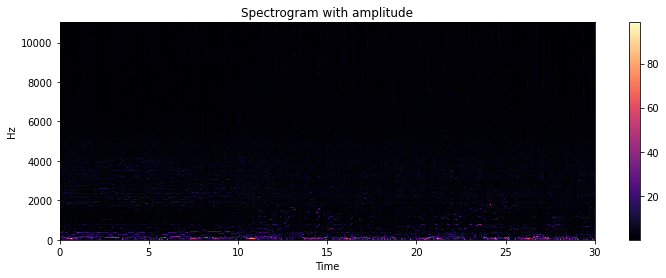

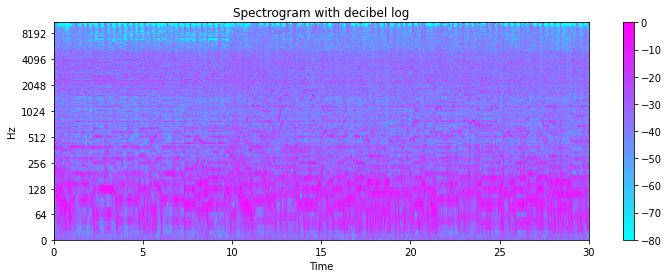

In [ ]:
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

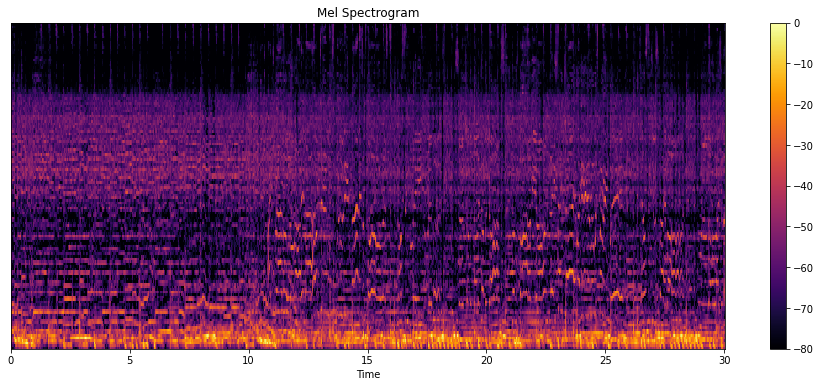

In [ ]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', cmap='inferno')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()
plt.save("metal.png")

imgdata/images_original/metal/metal00000.png


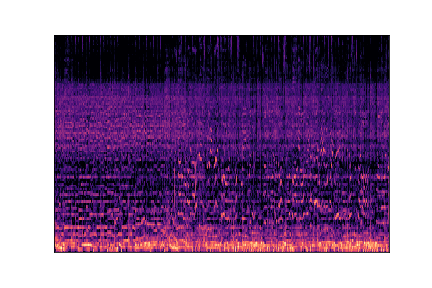

In [ ]:
from IPython.display import Image
import time

genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "rock", "reggae"]
filename = f'imgdata/images_original/{genres[6]}/{genres[6]}00000.png'
print(filename)
Image(filename=filename)


# Model

In [ ]:
!rm -rf shap

In [ ]:
!unzip genres_original.zip

In [ ]:

!unzip imgdata.zip

In [ ]:
pip install shap

In [ ]:
pip install optuna

In [ ]:
import os
import torch
import torchaudio
import optuna
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import torch.optim as optim
from torchvision.io import read_image
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torchaudio.datasets.utils import download_url
#from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
#from torchaudio.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

## Pre-process

In [ ]:
ft = pd.read_csv("imgdata/features_30_sec.csv")

In [ ]:
ft

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0    blues.00000.wav  661794          0.350088  ...     1.221291   46.936035  blues
1    blues.00001.wav  661794          0.340914  ...     0.531217   45.786282  blues
2    blues.00002.wav  661794          0.363637  ...    -2.231258   30.573025  blues
3    blues.00003.wav  661794          0.404785  ...    -3.407448   31.949339  blues
4    blues.00004.wav  661794          0.308526  ...   -11.703234   55.195160  blues
..               ...     ...               ...  ...          ...         ...    ...
995   rock.00095.wav  661794          0.352063  ...    -1.193787   49.950665   rock
996   rock.00096.wav  661794          0.398687  ...    -2.795338   31.773624   rock
997   rock.00097.wav  661794          0.432142  ...    -2.106337   29.865515   rock
998   rock.00098.wav  661794          0.362485  ...    -3.590644   41.299088   rock
999   rock.00099.wav  661794          0.358401  ...     1.155239   49.662510   rock

[1000 rows x 60 columns]

In [ ]:
annotations_file = "imgdata/features_30_sec.csv"
img_labels = pd.read_csv(annotations_file)
img_dir = "imgdata/images_original"
for idx in range(len(img_labels)):
  try:
    img_path = os.path.join(img_dir, img_labels.iloc[idx, -1], 
                                img_labels.iloc[idx, 0][:-4].replace(".", "")) + ".png"
    image = read_image(img_path)
  except:
    print(f"{img_path} does not exist")
    cp = img_labels.drop(idx, axis = 0).reset_index()


imgdata/images_original/jazz/jazz00054.png does not exist


In [ ]:
cp.drop("index", inplace = True, axis = 1)

In [ ]:
cp.to_csv("imgdata/features_30_sec_mod.csv", index=False)

In [ ]:
cp = pd.read_csv("imgdata/features_30_sec_mod.csv")

In [ ]:
from IPython.display import Image
import time

genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "rock", "reggae"]

filename = f'imgdata/images_original/{genres[2]}/{genres[2]}00000.png'
Image(filename=filename) 
read_image(filename)


### Start here:

In [ ]:
import os
import pandas as pd


class MusicDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, -1], 
                                self.img_labels.iloc[idx, 0][:-4].replace(".", "")) + ".png"
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, -1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
def target_transform_func(x):
  genres = {"blues":1, "classical":2, "country":3, 
            "disco":4, "hiphop":5, "jazz":6,
            "metal":7, "pop":8, "rock":9, "reggae":10}
  return genres[x]

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

target_transform = target_transform_func

annotations_file = "imgdata/features_30_sec_mod.csv"
img_dir = "imgdata/images_original"
dataset = MusicDataset(annotations_file, img_dir, target_transform=target_transform)

In [ ]:
len(dataset), len(pd.read_csv(annotations_file))

(999, 999)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_pc = 0.2

val_size = int(len(dataset)*val_pc)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(800, 199)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle = True)
valid_dl = DataLoader(val_ds, batch_size, shuffle = False)

In [ ]:
train_features, train_labels = next(iter(train_dl))

In [ ]:
train_features.shape

torch.Size([64, 4, 288, 432])

In [ ]:
len(set(train_labels))

64

Feature batch shape: torch.Size([64, 4, 288, 432])
Labels batch shape: 64
torch.Size([432, 288, 4])


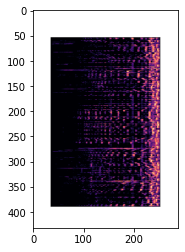

Label: 3


In [ ]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0]
print(img.T.shape)
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

# Training

### Model

In [ ]:
class MusicCNN(nn.Module):
    def __init__(self, in_channels ,num_classes, hidden_state, input_size, dropout, cv_kernal_size, mp_kernal_size):
        super().__init__()

        #cv_kernal_size = 3
        #mp_kernal_size = 4

        H, W = self.conv(input_size, cv_kernal_size)
        H, W = self.max_pool((64, hidden_state, H, W), mp_kernal_size)
        H, W = self.conv((64, hidden_state*2, H, W), cv_kernal_size)
        H, W = self.max_pool((64, hidden_state*2, H, W), mp_kernal_size)

        self.conv1 = nn.Conv2d(in_channels, hidden_state, cv_kernal_size)
        self.pool1 = nn.MaxPool2d(mp_kernal_size, mp_kernal_size)
        self.pool2 = nn.MaxPool2d(mp_kernal_size, mp_kernal_size)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(hidden_state, hidden_state*2, cv_kernal_size)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.fc1 = nn.Linear(hidden_state*2 * H * W, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        #x = self.dropout(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def max_pool(self, input_size, kernal_size):
        N, C, H, W = input_size
        H = (H - 1*(kernal_size-1)-1)/kernal_size + 1
        W = (W - 1*(kernal_size-1)-1)/kernal_size + 1
        return int(H), int(W)

    def conv(self, input_size, kernal_size):
        N, C, H, W = input_size
        H = (H - 1*(kernal_size-1)-1)/1 + 1
        W = (W - 1*(kernal_size-1)-1)/1 + 1
        return int(H), int(W)

_ , in_channels, _ , _ = train_features.size()
num_classes = len(set(train_labels))




### Training model

In [ ]:
device = torch.device("cpu")

In [ ]:
import optuna
from optuna.trial import TrialState
from tqdm import trange
import time
train_features, train_labels = next(iter(train_dl))
hidden_span_low = 12
hidden_span_high = 24
span = 2

hi = 1

def objective(trial):
  f = open("accuracy.txt", "r")
  max_accuracy = float(f.read())
  f.close()
  epochs = 60
  overfit_convergence = 3
  convergence = 0
  max_local_accuracy = 0
  criterion = nn.CrossEntropyLoss()
  
  lr = trial.suggest_float('lr', 1e-3, 1.5*1e-3)
  #lr = 1e-3
  hidden_size = trial.suggest_int('hidden size', hidden_span_low, hidden_span_high, step = span)
  #cv_kernal_size = trial.suggest_int("cv_ks", 2, 4, step = 1)
  #mp_kernal_size = trial.suggest_int("mp_ks", 2, 4, step = 1)
  cv_kernal_size = 2
  mp_kernal_size = 3
  dropout = trial.suggest_float("dropout", 0.0, 0.2)
  
  music_net = MusicCNN(in_channels ,num_classes, hidden_size, 
                       train_features.size(), dropout, cv_kernal_size = cv_kernal_size, mp_kernal_size = mp_kernal_size).to(device)
  optimizer = optim.Adam(music_net.parameters(), lr = lr)

  prev_accuracy = 0 
  
  epoch = 0
  while epoch < epochs:
  #for epoch in range(epochs):  # loop over the dataset multiple times
      start = time.time()
      running_loss = 0.0
      total = 0
      correct = 0
      music_net.train()
      for i, (inputs, labels) in enumerate(train_dl):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = music_net(inputs/255)

          loss = criterion(outputs, labels)
          loss.backward()

          optimizer.step()

          # print statistics
          running_loss += loss.item()

          acc_outputs = F.softmax(outputs, dim = 1)
          pred = acc_outputs.argmax(dim=1)
          total += labels.size(0)
          correct += pred.eq(labels.view_as(pred)).sum().item()

          #if i % 5 == 4:    # print every 2000 mini-batches
      print(f'[Epoch {epoch + 1}] train_loss: {running_loss / (i+1):.3f}, train_accuracy: {correct / total:.3f}', end=" ")
      
      #Validation
      music_net.eval()
      val_correct = 0
      val_total = 0
      with torch.no_grad():
          for batch_idx, (data, labels) in enumerate(valid_dl):
              data, labels = data.to(device), labels.to(device)
              val_outputs = music_net(data/255)
              # Get the index of the max log-probability.
              val_outputs = F.softmax(val_outputs, dim = 1)
              pred = val_outputs.argmax(dim=1)
              val_total += labels.size(0)
              # correct += (pred == labels).sum().item()
              val_correct += pred.eq(labels.view_as(pred)).sum().item()

      accuracy = val_correct / val_total

      if accuracy > max_accuracy:
        max_accuracy = accuracy
        with open('accuracy.txt', 'w') as f:
          f.write(f'{max_accuracy}')
        f.close()
        
        torch.save(music_net, "music_net.pt")
        print(f"Newest maximum accuracy has been saved: {max_accuracy}")
      
      if accuracy > max_local_accuracy:
        max_local_accuracy = accuracy
        convergence = 0

      if max_local_accuracy > accuracy:
        convergence += 1

      if  convergence > overfit_convergence:
        print(f"Convergence of validation data occured")
        return max_local_accuracy

      print(f"val_accuracy: {accuracy:.3f}", end = " ")
      print(f"time: {time.time()-start:.3f}")
      trial.report(accuracy, epoch)

      # Handle pruning based on the intermediate value.
      if trial.should_prune():
        print(f"Pruned params - lr: {lr}, hidden_size: {hidden_size}" )
        raise optuna.exceptions.TrialPruned()
      epoch += 1
  return max_local_accuracy

study = optuna.create_study(direction="maximize", study_name = f"CNNfinal8", 
                            storage='sqlite:///musicnet.db', load_if_exists=True)
study.optimize(objective, n_trials=10)


pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

In [ ]:
import optuna.visualization.matplotlib as ovm

In [ ]:
ovm.plot_optimization_history(study)
ovm.plot_param_importances(study)
#ovm.plot_contour(study)
#ovm.plot_intermediate_values(study)
ovm.plot_slice(study, params = ["hidden size", "lr", "dropout"])

### Test model

In [ ]:
music_net = torch.load("music_net.pt")

In [ ]:
study = optuna.create_study(direction="maximize", study_name = f"CNNfinal8", 
                            storage='sqlite:///musicnet.db', load_if_exists=True)
study.best_trial.params.items()

[I 2022-05-01 06:53:44,653] Using an existing study with name 'CNNfinal8' instead of creating a new one.


dict_items([('dropout', 0.08559235462230141), ('hidden size', 22), ('lr', 0.0012640119437939282)])

In [ ]:
genres_index = {1:"blues", 2:"classical", 3:"country", 
            4:"disco", 5:"hiphop", 6:"jazz",
            7:"metal", 8:"pop", 9:"rock", 10:"reggae"}

In [ ]:
val_correct = 0
val_total = 0
dropout = 0.08559235462230141
hidden_size = 22
lr = 0.0012640119437939282
epochs = 30
cv_kernal_size = 2
mp_kernal_size = 3
criterion = nn.CrossEntropyLoss()
music_net = MusicCNN(in_channels ,num_classes, hidden_size, 
                       train_features.size(), dropout, cv_kernal_size = cv_kernal_size, mp_kernal_size = mp_kernal_size).to(device)
optimizer = optim.Adam(music_net.parameters(), lr = lr)

for epoch in range(epochs):
  running_loss = 0.0
  total = 0
  correct = 0
  music_net.train()
  for i, (inputs, labels) in enumerate(train_dl):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = music_net(inputs/255)

    loss = criterion(outputs, labels)
    loss.backward()

    optimizer.step()

    # print statistics
    running_loss += loss.item()

    acc_outputs = F.softmax(outputs, dim = 1)
    pred = acc_outputs.argmax(dim=1)
    total += labels.size(0)
    correct += pred.eq(labels.view_as(pred)).sum().item()
    #for t in range(len(pred)):
    #  train_map.loc[pred[t], labels[t]] += 1

          #if i % 5 == 4:    # print every 2000 mini-batches
  accuracy = correct / total
  print(f'[Epoch {epoch + 1}] train_loss: {running_loss / (i+1):.3f}, train_accuracy: {accuracy:.3f}', end=" ")
    #if accuracy >= 0.7135678391959799:
    #  break
  music_net.eval()
  val_correct = 0
  val_total = 0
  with torch.no_grad():
      for batch_idx, (data, labels) in enumerate(valid_dl):
          data, labels = data.to(device), labels.to(device)
          val_outputs = music_net(data/255)
            # Get the index of the max log-probability.
          val_outputs = F.softmax(val_outputs, dim = 1)
          pred = val_outputs.argmax(dim=1)
          val_total += labels.size(0)
            # correct += (pred == labels).sum().item()
          val_correct += pred.eq(labels.view_as(pred)).sum().item()
          #for v in range(len(pred)):
          #  test_map.loc[pred[v], labels[v]] += 1

  accuracy = val_correct / val_total
  print(f"val_accuracy: {accuracy:.3f}")
  if accuracy >= 0.68:
    print(f"Finished traning - accuracy: {accuracy}")
    torch.save(music_net.state_dict(), "music_net_state_dict.pt")
    torch.save(music_net, "music_net_new.pt")
    break


[Epoch 1] train_loss: 2.943, train_accuracy: 0.070 val_accuracy: 0.106
[Epoch 2] train_loss: 2.304, train_accuracy: 0.159 val_accuracy: 0.216
[Epoch 3] train_loss: 2.086, train_accuracy: 0.239 val_accuracy: 0.427
[Epoch 4] train_loss: 1.884, train_accuracy: 0.331 val_accuracy: 0.387
[Epoch 5] train_loss: 1.606, train_accuracy: 0.426 val_accuracy: 0.462
[Epoch 6] train_loss: 1.411, train_accuracy: 0.515 val_accuracy: 0.558
[Epoch 7] train_loss: 1.207, train_accuracy: 0.603 val_accuracy: 0.482
[Epoch 8] train_loss: 1.069, train_accuracy: 0.642 val_accuracy: 0.573
[Epoch 9] train_loss: 0.960, train_accuracy: 0.666 val_accuracy: 0.648
[Epoch 10] train_loss: 0.743, train_accuracy: 0.744 val_accuracy: 0.628
[Epoch 11] train_loss: 0.642, train_accuracy: 0.804 val_accuracy: 0.638
[Epoch 12] train_loss: 0.488, train_accuracy: 0.859 val_accuracy: 0.643
[Epoch 13] train_loss: 0.357, train_accuracy: 0.904 val_accuracy: 0.638
[Epoch 14] train_loss: 0.243, train_accuracy: 0.945 val_accuracy: 0.683
F

### Extra test

In [ ]:
dropout = 0.08559235462230141
hidden_size = 22
lr = 0.0012640119437939282
cv_kernal_size = 2
mp_kernal_size = 3
music_net = MusicCNN(in_channels ,num_classes, hidden_size, 
                       train_features.size(), dropout, cv_kernal_size = cv_kernal_size, mp_kernal_size = mp_kernal_size).to(device)
music_net.load_state_dict(torch.load("music_net_state_dict.pt"))

<All keys matched successfully>

In [ ]:
f1_map = {1: [0]*10, 
            2: [0]*10, 
            3: [0]*10, 
            4: [0]*10, 
            5: [0]*10, 
            6: [0]*10, 
            7: [0]*10, 
            8: [0]*10, 
            9: [0]*10, 
            10: [0]*10}
train_map = pd.DataFrame(f1_map,index = [1,2,3,4,5,6,7,8,9,10])
test_map = pd.DataFrame(f1_map,index = [1,2,3,4,5,6,7,8,9,10])

In [ ]:
music_net.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = data.to(device), labels.to(device)
        val_outputs = music_net(data/255)
            # Get the index of the max log-probability.
        val_outputs = F.softmax(val_outputs, dim = 1)
        pred = val_outputs.argmax(dim=1)
        val_total += labels.size(0)
            # correct += (pred == labels).sum().item()
        val_correct += pred.eq(labels.view_as(pred)).sum().item()
        for v in range(len(pred)):
          train_map.loc[int(pred[v]), int(labels[v])] += 1

accuracy = val_correct / val_total
print(f"val_accuracy: {accuracy:.3f}")

val_accuracy: 0.986


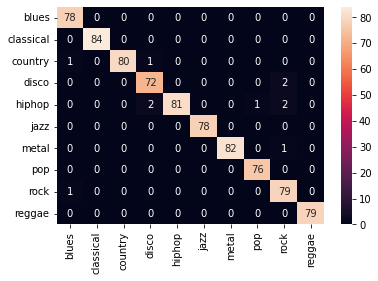

In [ ]:
sns.heatmap(train_map.rename(columns= genres_index, index = genres_index), annot=True)


In [ ]:
music_net.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for batch_idx, (data, labels) in enumerate(valid_dl):
        data, labels = data.to(device), labels.to(device)
        val_outputs = music_net(data/255)
            # Get the index of the max log-probability.
        val_outputs = F.softmax(val_outputs, dim = 1)
        pred = val_outputs.argmax(dim=1)
        val_total += labels.size(0)
            # correct += (pred == labels).sum().item()
        val_correct += pred.eq(labels.view_as(pred)).sum().item()
        for v in range(len(pred)):
          test_map.loc[int(pred[v]), int(labels[v])] += 1

accuracy = val_correct / val_total
print(f"val_accuracy: {accuracy:.3f}")

val_accuracy: 0.683


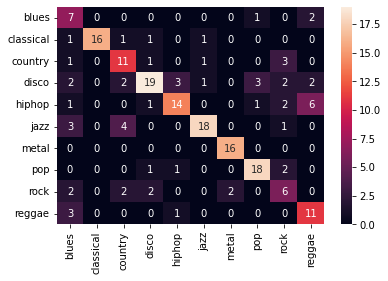

In [ ]:
sns.heatmap(test_map.rename(columns= genres_index, index = genres_index), annot=True)

### Explainability: Shap

In [ ]:
dropout = 0.08559235462230141
hidden_size = 22
lr = 0.0012640119437939282
cv_kernal_size = 2
mp_kernal_size = 3
music_net = MusicCNN(in_channels ,num_classes, hidden_size, 
                       train_features.size(), dropout, cv_kernal_size = cv_kernal_size, mp_kernal_size = mp_kernal_size).to(device)
music_net.load_state_dict(torch.load("music_net_state_dict.pt"))

<All keys matched successfully>

In [ ]:
print(len(train_ds), len(val_ds))

800 199


In [ ]:
def normalize(image):
    image /= 255
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [ ]:
import shap

In [ ]:
music_net_features = [1,2,3,4,5,6,7,8,9,10]
index_names = ("blues", "classical", "country", 
            "disco", "hiphop", "jazz",
            "metal", "pop", "rock","reggae")



train_dl = DataLoader(train_ds, batch_size = 256, shuffle = True)
valid_dl = DataLoader(val_ds, batch_size = len(val_ds), shuffle = False)

batch = next(iter(train_dl))
images, labels = batch

background = (images[:-8]/255).float()
test_images = (images[-8:]/255).float()

In [ ]:
e = shap.GradientExplainer(music_net, test_images)
shap_values,indexes = e.shap_values(background, ranked_outputs=2, nsamples=20)

print(np.array(shap_values).shape)
print(test_images.numpy().shape)
# plot the explanations

(2, 248, 4, 288, 432)
(8, 4, 288, 432)


In [ ]:
test_images = np.array(np.swapaxes(np.swapaxes(test_images, 2, 3), 1, -1))

In [ ]:
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

In [ ]:
labels[-8:]

tensor([ 5,  8, 10,  2,  4,  9,  6,  2])

In [ ]:
shap.plots.image(shap_values, test_images, indexes)

In [ ]:
import shap
music_net_features = [1,2,3,4,5,6,7,8,9,10]
index_names = ("blues", "classical", "country", 
            "disco", "hiphop", "jazz",
            "metal", "pop", "rock","reggae")



train_dl = DataLoader(train_ds, batch_size = 64, shuffle = False)
valid_dl = DataLoader(val_ds, batch_size = len(val_ds), shuffle = False)

batch = next(iter(train_dl))
images, labels = batch

background = (images[:-8]/255).float()
test_images = (images[-2:]/255).float()

print(background.shape)
print(test_images.shape)

e = shap.DeepExplainer(music_net, background)
shap_values, indexes = e.shap_values(test_images, ranked_outputs = 4)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

torch.Size([56, 4, 288, 432])
torch.Size([2, 4, 288, 432])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
genres_index = {1:"blues", 2:"classical", 3:"country", 
            4:"disco", 5:"hiphop", 6:"jazz",
            7:"metal", 8:"pop", 9:"rock", 10:"reggae"}
index_names = np.asarray([[genres_index[int(i)] for i in row] for row in indexes])

tensor([8, 1])


invalid value encountered in true_divide
invalid value encountered in true_divide


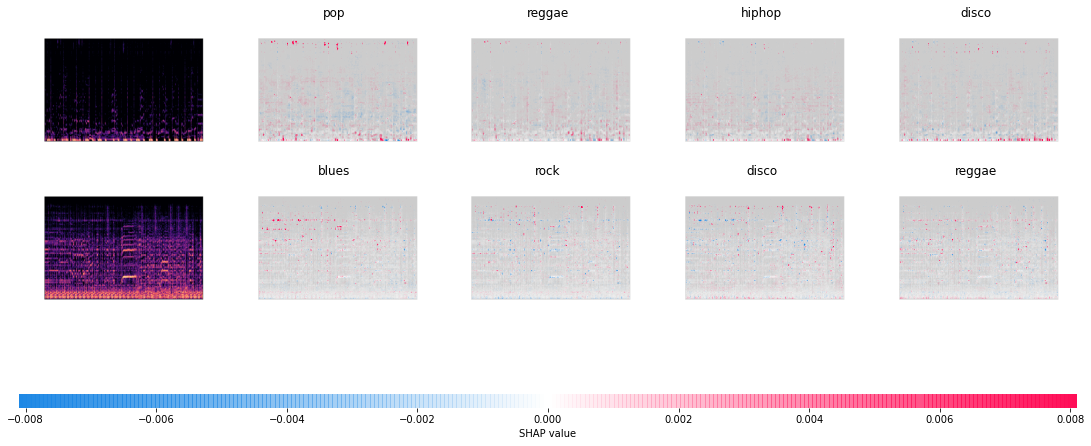

In [ ]:
# plot the feature attributions


print(labels[-2:])


#index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

'''
Jazz 36
Rock 54
Metal 86
Reggae 68
Classical 4
Jazz 51/Jazz 33
Pop 97
Blues 79
'''

shap.image_plot(shap_numpy, test_numpy, index_names, hspace="auto")

In [ ]:
l = [1,2,3,4,5, 5,5,4]

l[0:2]



[1, 2]

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
invalid value encountered in true_divide
invalid value encountered in true_divide


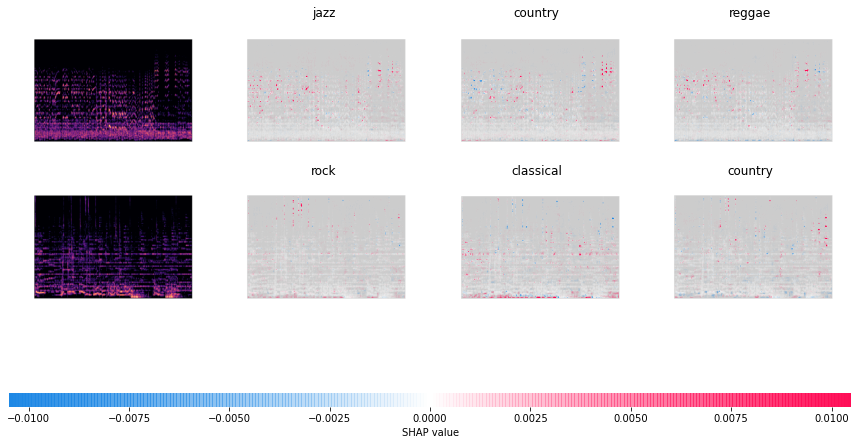

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
invalid value encountered in true_divide
invalid value encountered in true_divide


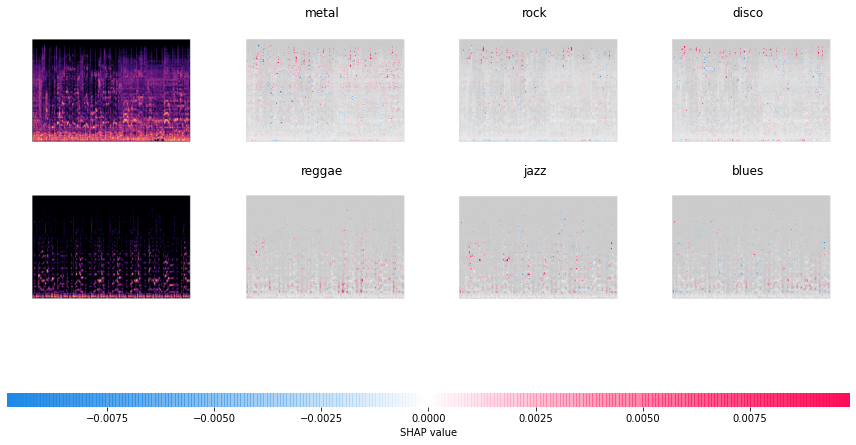

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
invalid value encountered in true_divide
invalid value encountered in true_divide


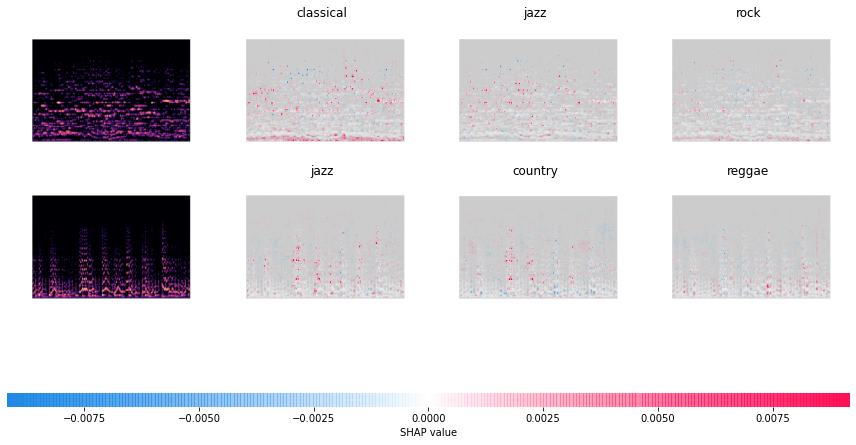

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
invalid value encountered in true_divide
invalid value encountered in true_divide


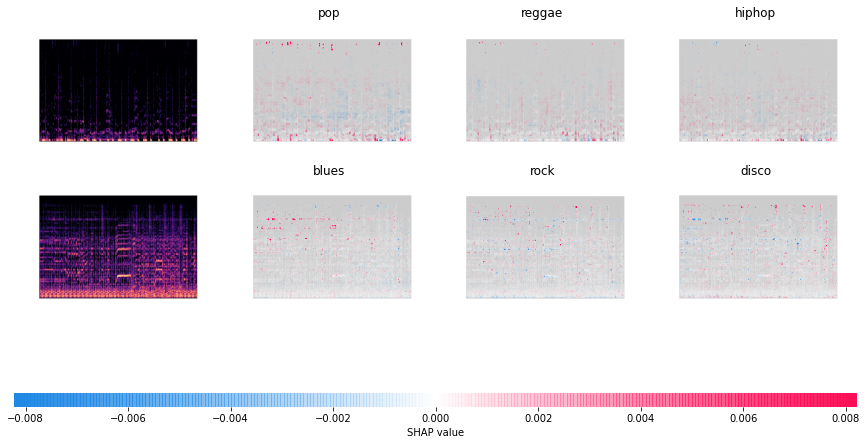

In [ ]:

music_net_features = [1,2,3,4,5,6,7,8,9,10]
index_names = ("blues", "classical", "country", 
            "disco", "hiphop", "jazz",
            "metal", "pop", "rock","reggae")



train_dl = DataLoader(train_ds, batch_size = 64, shuffle = False)
valid_dl = DataLoader(val_ds, batch_size = len(val_ds), shuffle = False)

batch = next(iter(train_dl))
images, labels = batch

background = (images[:-8]/255).float()
test_images = (images[-8:]/255).float()

e = shap.DeepExplainer(music_net, background)

for i in [0, 2, 4, 6]:
  test_images_new = test_images[i:i+2]
  #e = shap.DeepExplainer(music_net, background)
  shap_values, indexes = e.shap_values(test_images_new, ranked_outputs = 3)
  shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
  test_numpy = np.swapaxes(np.swapaxes(test_images_new.cpu().numpy(), 1, -1), 1, 2)

  genres_index = {1:"blues", 2:"classical", 3:"country", 
            4:"disco", 5:"hiphop", 6:"jazz",
            7:"metal", 8:"pop", 9:"rock", 10:"reggae"}
  index_names = np.asarray([[genres_index[int(i)] for i in row] for row in indexes])
  shap.image_plot(shap_numpy, test_numpy, index_names, hspace="auto")